## DNN

In [101]:
M = 100 # change this value [20 or 60 or 100]
channel = 'DL' # change this [DL or SL]
dotrain = False
dofeatplot = False

import os
import sys
from glob import glob
import random
import string
import yaml
import pandas as pd
import root_pandas as rpd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
from collections import defaultdict
#import ROOT
import copy
import tensorflow.keras
import tensorflow.saved_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.utils.vis_utils import plot_model                                                                                                                
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, f1_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from pickle import dump
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight
import enlighten
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
#tensorflow.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [102]:
############ plot function for input features ############
def plotinputfeatures(featuredict, df_sig, df_bkg, tag=''):
    for feat in featurelist:
        feat_info = featuredict.get(feat)
        nbins  = feat_info[0]
        xlow   = feat_info[1]
        xhigh  = feat_info[2]
        nbins_ = np.linspace(xlow, xhigh, nbins)
        feat_sig = df_sig[feat].to_numpy()
        feat_bkg = df_bkg[feat].to_numpy()
        y_s,bins_s,patches_s = plt.hist(feat_sig,nbins_,density=True,histtype='stepfilled',
                                        alpha=0.5,lw=2,log=False, label = 'Signal')
        y_b,bins_b,patches_b = plt.hist(feat_bkg,nbins_,density=True,histtype='stepfilled',
                                        alpha=0.5,lw=2,log=False, label = 'Background')
    
        plt.xlabel(feat, fontsize=18)
        plt.ylabel('Normalised events', fontsize=18)
        plt.xticks(size = 18)
        plt.yticks(size = 18)
        plt.legend(loc='best', fontsize=16)
        plt.grid(True)
        
        plt.savefig(os.path.join(tagdir,feat+tag+'.png'), dpi=300)
        plt.show()
        plt.clf()
##########################################################
def PlotHistory(history, modelparamdict):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    #variables += ["lr"]
    N = len(variables)
    fig, ax = plt.subplots(N,2,figsize=(12.5,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    #----- Print parameters -----#
    parstr = 'Parameters : \n'
    for key, val in modelparamdict.items():
        temp = ' '.join([str(x) for x in val])
        parstr = parstr+key+' : '+temp+'\n'
    
    plt.gcf().text(0.6, 0.5, parstr, fontsize=14)
    # Save #
    #rand_hash = ''.join(random.choice(string.ascii_uppercase) for _ in range(10)) # avoids overwritting
    png_name = 'Loss_Acc_LR.png'
    fig.savefig(os.path.join(tagdir,png_name), dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################

In [103]:
# Load config
### open config.yaml and get all the necessary parameters
with open(os.path.join('Yamls', f'config_train_MX{M}_{channel}.yaml'), 'r') as inf:
    config = yaml.safe_load(inf)
    
mainkeys    = list(config.keys())
tag         = config.get('Tag')
tagdir      = os.path.join(os.getcwd(),tag)

if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f'{tagdir} already exists ...')

maintree       = config.get('intree')
infiledict     = config.get('infiles')
featuredict    = config.get('features')
featurelist    = list(featuredict.keys())
print(f'feature list : {featurelist}')
signaldict     = infiledict.get('Signal')
backgrounddict = infiledict.get('Background')
scale          = config.get('DoScaling')
#dotrain        = config.get('DoTrain')

modelparamdict = config.get('modelParams')
LayerDims   = modelparamdict.get('Layers')
IsBatchNorm = modelparamdict.get('BatchNorms')
DropOuts    = modelparamdict.get('Dropout')
L2regs      = modelparamdict.get('L2')
Activations = modelparamdict.get('activ')

trainingparamdict = config.get('trainingParams')
LossFunc = trainingparamdict.get('Loss')
LRate    = trainingparamdict.get('LR')
print(f'Learning rate : {LRate}')
Metrics  = trainingparamdict.get('Metrics')
valSplit = trainingparamdict.get('valSplit')
nEpoch   = trainingparamdict.get('epoch') 
opt      = tensorflow.keras.optimizers.Adam(learning_rate=LRate)
batchsize = trainingparamdict.get('BatchSize')
print(f'Batch size : {batchsize}')

# Prepare train-test datasets (panda df)
### Use root_panda to get the event info from root files

##################################################################
##################################################################
signal_info_list     = list(signaldict.values())
background_info_list = list(backgrounddict.values())

print(signal_info_list)
print(background_info_list)

dfs_signal     = []
dfs_background = []
for item in signal_info_list:
    path   = item[0]
    xsec   = item[1] # xsec
    nEvProd= item[2]   
    dfitem = rpd.read_root(path, key=maintree)[featurelist]
    dfitem['tag'] = 1
    #dfitem['tag'] = np.ones(dfitem.shape[0])
    #dfitem['wtd_events'] = np.ones(dfitem.shape[0])
    ##dfitem['wtd_events'] = dfitem.shape[0]
    dfitem['wt'] = 1.0/nEvProd
    #dfitem['wt'] = 1.0
    dfs_signal.append(dfitem)

for item in background_info_list:
    path  = item[0]
    xsec  = item[1] # xsec
    nEvProd= item[2]
    dfitem = rpd.read_root(path, key=maintree)[featurelist]
    #dfitem['tag'] = np.zeros(dfitem.shape[0])
    dfitem['tag'] = 0
    #dfitem['wtd_events'] = xsec*np.ones(dfitem.shape[0])
    #dfitem['wtd_events'] = xsec*dfitem.shape[0]
    dfitem['wt'] = xsec/nEvProd
    dfs_background.append(dfitem)

print(f'No of signal processes : {len(dfs_signal)}, bkg processes : {len(dfs_background)}')

df_total_sig = pd.concat(dfs_signal)
df_total_sig['rel_weight'] = 1.0

totwt = 0.0
for df in dfs_background:
    print(f'''backgrounddddddd : {df['wt']}  : shape : {df.shape[0]} \n\n''')
    totwt += df['wt'][0] * df.shape[0]

for df in dfs_background:
    df['rel_weight'] = df['wt'] * df.shape[0] / totwt
    
df_total_bkg = pd.concat(dfs_background)      


print(f'Total bkg weight : {totwt}\n\n\n')
'''
df_total_sig = pd.concat(dfs_signal) # panda df for all signals
df_total_background = pd.concat(dfs_background) # panda df for all backgrounds

#df_total_sig['rel_weight'] = (1/df_total_sig.shape[0])*np.ones(df_total_sig.shape[0])
df_total_sig['rel_weight'] = 1
nEffectiveBackgrounds = df_total_background['wtd_events'].sum()

for df in dfs_background:
    #df['rel_weight'] = df['wtd_events']/nEffectiveBackgrounds*np.ones(df.shape[0])
    df['rel_weight'] = df['wtd_events']/nEffectiveBackgrounds
    
df_total_bkg = pd.concat(dfs_background)    
'''    

print(f'df_Signal shape      : {df_total_sig.shape}')
#print(df_total_sig.head())
print(f'df_Background shape  : {df_total_bkg.shape}')    
#print(df_total_bkg.head())    
    
if dofeatplot : 
    plotinputfeatures(featuredict, df_total_sig, df_total_bkg, tag='_raw')    
    # Correlation matrices
    ### Both for signal and background
    ################### For Correlation matrix ######################
    df_sig = df_total_sig[featurelist + ['tag']].iloc[:,:-1]
    df_bkg = df_total_bkg[featurelist + ['tag']].iloc[:,:-1]
    corrlMatrix_sig = df_sig.corr()
    corrlMatrix_bkg = df_bkg.corr()

    plt.figure(figsize=(15,12.5))
    #sns.heatmap(corrlMatrix_sig, cmap='YlGnBu', annot=True, annot_kws={'size':13}, fmt='.2f')
    sns.heatmap(corrlMatrix_sig, cmap='YlGnBu', annot=False)
    plt.title('Correlation Matrix [Signal]')
    plt.savefig(os.path.join(tagdir,'Corr_matrix_signal.png'), dpi=300)
    plt.show()
    plt.clf()
    plt.figure(figsize=(15,12.5))
    #sns.heatmap(corrlMatrix_bkg, cmap='YlGnBu', annot=True, annot_kws={'size':13}, fmt='.2f')
    sns.heatmap(corrlMatrix_bkg, cmap='YlGnBu', annot=False)
    plt.title('Correlation Matrix [Background]')
    plt.savefig(os.path.join(tagdir,'Corr_matrix_bkg.png'), dpi=300)
    plt.show()
    plt.clf()
    #################################################################
#df_total_sig.abs()
#df_total_bkg.abs()

sigtrain,  sigtest  = train_test_split(df_total_sig,  test_size=0.2,   random_state=42, shuffle=True)
bkgtrain,  bkgtest  = train_test_split(df_total_bkg,  test_size=0.2,   random_state=42, shuffle=True)

df_train = pd.concat([sigtrain,bkgtrain])
df_train.sample(frac=1)
df_test  = pd.concat([sigtest,bkgtest])
df_test.sample(frac=1)


neg, pos = np.bincount(df_train['tag'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


#df_train = df_train[featurelist + ['tag']]
#df_test  = df_test[featurelist + ['tag']]

#print(f'df_TRAIN shape : {df_train.shape}')
#print(f'df_TEST shape  : {df_test.shape}')


# Keep the sample weights separate
train_weight = df_train [['rel_weight']].to_numpy()
test_weight  = df_test  [['rel_weight']].to_numpy()

df_train = df_train[featurelist + ['tag']]
df_test  = df_test [featurelist + ['tag']]

# Prepare train and test datasets
np_train = df_train.to_numpy()
np_test  = df_test.to_numpy()

x_train = np_train[:,:np_train.shape[1]-1]
y_train_ = np_train[:,-1].reshape(-1,1)
y_train = to_categorical(y_train_, 2)
print(f'Shape of x_train : {x_train.shape}')
x_test  = np_test[:,:np_test.shape[1]-1]
y_test_  = np_test[:,-1].reshape(-1,1)
y_test  = to_categorical(y_test_, 2)
print(f'Shape of x_test : {x_test.shape}')

print(f'Train --> Sig : {np.sum(y_train > 0)}   Bkg : {np.sum(y_train < 1)}')
print(f'Test  --> Sig : {np.sum(y_test > 0)}    Bkg : {np.sum(y_test < 1)}')

# Scalar
print(f'Do Scaling of input features : {scale}')
from sklearn import preprocessing
#scaler = preprocessing.StandardScaler()
scaler  = preprocessing.RobustScaler()
#scaler  = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train) if scale else x_train
x_test  = scaler.transform(x_test) if scale else x_test
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
dump(scaler, open(os.path.join(tagdir,'scaler.pkl'), 'wb'))


#clsWt = class_weight.compute_class_weight('balanced', np.unique(np_train[:,-1]), np_train[:,-1])
#clsWt = dict(zip(np.unique(np_train[:,-1]), 
#                 class_weight.compute_class_weight('balanced', np.unique(np_train[:,-1]), 
#                                                   np_train[:,-1])))
#print(clsWt)
initbias = np.log(pos/neg)

/home/gsaha/Work/DelphesML/Project2/DNN/DL_MX_100_Final already exists ...
feature list : ['pt_tauh', 'eta_tauh', 'met', 'pt_leadbj', 'eta_leadbj', 'pt_leadlj', 'eta_leadlj', 'pt_xlep', 'eta_xlep', 'pt_wlep', 'eta_wlep', 'vectorsumpt_xlep_wlep', 'dr_xlep_wlep', 'dphi_wlep_tauh', 'dphi_wlep_leadbj', 'ht_jets', 'dr_min_xlep_jets', 'dr_min_wlep_jets', 'dphi_xlep_tauh', 'dr_min_jets', 'mt_wlep_met', 'dphi_tauh_leadbj', 'dphi_met_xlep', 'dphi_met_wlep', 'dphi_leadbj_leadlj', 'dr_tauh_leadlj', 'met_along_tauh', 'costhetaS_xlep_tau', 'smin']
Learning rate : 0.0001
Batch size : 3000
[['/home/gsaha/Work/Delphes_Analyses/Project_FCNC_TTbar/JobOutput_MX_100/results/Sig_MX_100_MH_160_DL_mvaIn.root', 0.0225, 700000, 'signal']]
[['/home/gsaha/Work/Delphes_Analyses/Project_FCNC_TTbar/JobOutput_MX_60/results/Bkg_TTJets_DiLep_Set_New_DL_BDTD_mvaIn.root', 107.65, 18975410, 'TT + Jets'], ['/home/gsaha/Work/Delphes_Analyses/Project_FCNC_TTbar/JobOutput_MX_60/results/Bkg_TTJets_SingleLep_DL_BDTD_mvaIn.root

(213110, 29) (53279, 29) (213110, 2) (53279, 2)


In [104]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#######################################################################
#clsWt = {0:0.5*sigtrain.shape[0]/(sigtrain.shape[0]+bkgtrain.shape[0]), 
#         1:0.5*bkgtrain.shape[0]/(sigtrain.shape[0]+bkgtrain.shape[0])}
#print(clsWt)
#sigclswt = sigtrain.shape[0]/bkgtrain.shape[0] if sigtrain.shape[0] < bkgtrain.shape[0] else bkgtrain.shape[0]/sigtrain.shape[0]
#bkgclswt = 1/sigclswt
#clsWt    = {0 : sigclswt, 1 : 0.1*bkgclswt}
# ----------------------------------------------- #
# low signal weight shows better result
# need to find ref
# ----------------------------------------------- #
fac = 0.2 if channel == 'DL' else 0.07
wt0 = (1/neg)*(total/2.0)
wt1 = (1/pos)*(total/2.0)
clsWt = {0: wt0, 1: fac*wt1}
print(clsWt)
#######################################################################
if dotrain:
    # Build model 
    ### Binary-classification
    model = Sequential()
    for i in range(len(LayerDims)):
        if i == 0:
            
            model.add(Dense(LayerDims[i], 
                        input_dim=len(featurelist), 
                        #activation=Activations[i], 
                        activation=LeakyReLU(),    
                        kernel_regularizer=regularizers.l2(L2regs[i])))
            '''
            model.add(Dense(LayerDims[i], 
                        input_dim=len(featurelist), 
                        activation=Activations[i]))
            '''
        else:
            
            model.add(Dense(LayerDims[i], 
                            #activation=Activations[i],
                            activation=LeakyReLU(),
                            kernel_regularizer=regularizers.l2(L2regs[i])))    
            '''
            model.add(Dense(LayerDims[i], activation=Activations[i]))    
            '''
        model.add(BatchNormalization()) if IsBatchNorm[i] else None
        model.add(Dropout(DropOuts[i]))


    #model.add(Dense(2, activation='softmax'))
    model.add(Dense(2, activation='sigmoid'))
    #model.add(Dense(2, activation='sigmoid'))
    model.summary()

    # Compile and fit
    #set early stopping monitor so the model stops training when it won't improve anymore                                                                     
    #early_stopping_monitor = EarlyStopping(patience=3)                                                                                                       
    # https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd                                              
    custom_early_stopping = EarlyStopping(
        monitor='val_loss',
        #monitor='loss',
        #patience=int(nEpoch/10),
        patience=20,                                                                                                                                         
        min_delta=0.0001,
        verbose=1,
        restore_best_weights=True,
        #restore_best_weights=False,                                                                                                                          
        mode='min'
        #mode='max'                                                                                                                                           
    )
    #https://keras.io/api/callbacks/reduce_lr_on_plateau/                                                                                                     
    custom_ReduceLROnPlateau = ReduceLROnPlateau(
        monitor="val_loss",
        #monitor="loss",                                                                                                                  
        factor=0.5, #0.1
        #patience=5,                                                                                                                                          
        patience=10,
        verbose=1,
        mode="min",
        #mode="max",                                                                                                                                          
        cooldown=0,                                                                                                                                          
        #cooldown=5,
        #min_lr=0
        min_lr=1e-7,                                                                                                                                         
        min_delta=0.0001                                                                                                                                      
    )
    '''
    #model checkpoint
    #https://keras.io/api/callbacks/model_checkpoint/
    custom_ModelChkp = ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        options=None,
        initial_value_threshold=None,
        **kwargs
    )
    '''
    #custom loss-history with batch
    #https://github.com/cp3-llbb/HHbbWWAnalysis/blob/master/MachineLearning/HHMachineLearning/Model.py#L47
    class LossHistory(Callback):
        """ Records the history of the training per epoch and per batch """
        def on_train_begin(self, logs={}):
            self.epochs  = defaultdict(list) 
            self.batches = defaultdict(list) 
            self.pre_batch = 0

        def on_batch_end(self, batch, logs={}):
            self.batches['batch'].append(batch+self.pre_batch)
            for key,val in logs.items():
                self.batches[key].append(val)
            self.batches['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
            #loss = logs.get('loss')
            #print(f'\nBatch : {batch} with average loss : {loss}')

        def on_epoch_end(self, epoch, logs={}):
            self.epochs['epoch'].append(epoch)
            for key,val in logs.items():
                self.epochs[key].append(val)
            self.epochs['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
            self.pre_batch = self.batches['batch'][-1] 

    loss_history = LossHistory()
    model.compile(loss=LossFunc, 
                  optimizer=opt, 
                  metrics=[tensorflow.keras.metrics.CategoricalAccuracy(),
                           tensorflow.keras.metrics.AUC(),
                           tensorflow.keras.metrics.Precision(),
                           tensorflow.keras.metrics.Recall()])
    plot_model(model, to_file=os.path.join(tagdir,'modelDNN.png'),show_shapes=True,show_layer_names=True)
    callback_list = [custom_early_stopping, custom_ReduceLROnPlateau, loss_history]
    #callback_list = [custom_ReduceLROnPlateau, loss_history]
    history = model.fit(x_train, y_train, 
                        sample_weight=train_weight,
                        epochs=nEpoch, 
                        batch_size=batchsize, 
                        validation_split=valSplit,
                        verbose=1, 
                        #class_weight=None, 
                        class_weight=clsWt, 
                        use_multiprocessing=True,
                        callbacks=callback_list)
    
    
    
    # PLot History
    PlotHistory(loss_history, modelparamdict)
    # Loss and accuracy
    trainKeys = [key for key in history.history.keys() if not 'val' in key]
    valKeys   = [key for key in history.history.keys() if 'val' in key]
    #plt.style.use('seaborn')
    print(history.history.keys())
    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('loss'),'g-',linewidth=2)
    plt.plot(history.history.get('val_loss'),'r-',linewidth=2)
    plt.legend(['Train loss', 'Validation loss'], 
                loc='best',ncol=2,fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'Loss.png'), dpi=300)
    plt.show()
    plt.clf()

    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('categorical_accuracy'),'g-',linewidth=2)
    plt.plot(history.history.get('val_categorical_accuracy'),'r-',linewidth=2)
    #plt.plot(history.history.get('accuracy'),'g-',linewidth=2)
    #plt.plot(history.history.get('val_accuracy'),'r-',linewidth=2)
    plt.legend(['Train accuracy', 'Validation accuracy'], 
                loc='best',ncol=2,fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'Accuracy.png'), dpi=300)
    plt.show()
    plt.clf()
    '''
    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('lr'),'g-',linewidth=2)
    plt.legend(['LR'],loc='best',fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'LR.png'), dpi=300)
    plt.show()
    plt.clf()
    '''
    model_json = model.to_json()
    with open(os.path.join(tagdir,"DNN_model.json"), "w") as jfile:
        jfile.write(model_json)
    model.save_weights(os.path.join(tagdir,"DNN_model.h5"))
    print("Saved model to disk")

'''    
else:
    json_file  = open(os.path.join(tagdir,"DNN_model.json"), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model                                                                                                                             
    model.load_weights(os.path.join(tagdir,"DNN_model.h5"))
    print("Loaded model from disk")

    print(model)
'''

{0: 0.8954051192416935, 1: 0.226452586390105}


'    \nelse:\n    json_file  = open(os.path.join(tagdir,"DNN_model.json"), \'r\')\n    model_json = json_file.read()\n    json_file.close()\n    model = model_from_json(model_json)\n    # load weights into new model                                                                                                                             \n    model.load_weights(os.path.join(tagdir,"DNN_model.h5"))\n    print("Loaded model from disk")\n\n    print(model)\n'

# Test

Loaded model from disk
[1] to_categorical --> [[0. 1.]]
prediction probabilities for test dataset :
 [[0.6881353  0.297585  ]
 [0.31470466 0.68496275]
 [0.26128188 0.737121  ]
 ...
 [0.978725   0.02479848]
 [0.42327103 0.56371397]
 [0.923203   0.08447859]]
y_test : 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
y_predication :
 [0 1 1 ... 0 1 0]
y_true :
 [1 1 1 ... 0 0 0]


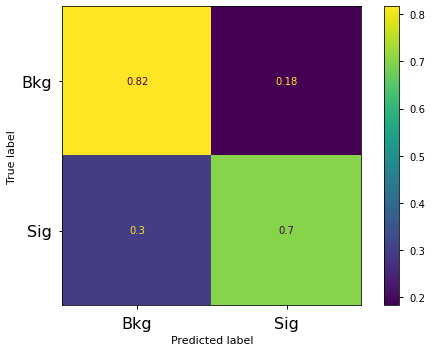

<Figure size 576x396 with 0 Axes>

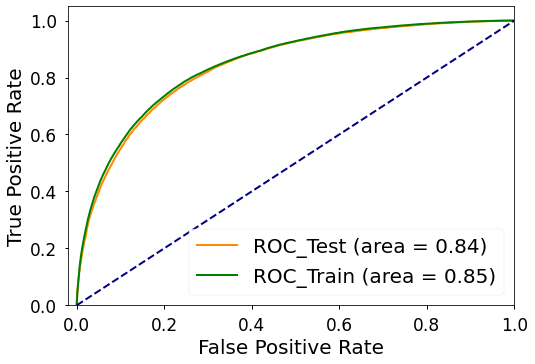

In [105]:
json_file  = open(os.path.join(tagdir,"DNN_model.json"), 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model                                                                                                                             
model.load_weights(os.path.join(tagdir,"DNN_model.h5"))
print("Loaded model from disk")
print(model)

raw = np.asarray([1])
raw_cat = to_categorical(raw, 2)
print(f'{raw} to_categorical --> {raw_cat}')

score_train   = model.predict(x_train)
score_test    = model.predict(x_test)
print(f'prediction probabilities for test dataset :\n {score_test}')
y_predProbaNoCutOnProb = score_test[:,-1]
y_predClassNoCutOnProb = np.asarray([np.argmax(item) for item in score_test])
y_true                 = y_test[:,-1].astype(int)
y_predProbaNoCutOnProbTrain = score_train[:,-1]
y_predClassNoCutOnProbTrain = np.asarray([np.argmax(item) for item in score_train])
y_trueTrain                 = y_train[:,-1].astype(int)
print(f'y_test : \n {y_test}')
print(f'y_predication :\n {y_predClassNoCutOnProb}')
print(f'y_true :\n {y_true}')
cnf_matrix = confusion_matrix(y_true, y_predClassNoCutOnProb, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.xticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.yticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.savefig(os.path.join(tagdir,'conf_matrix.png'), dpi=300)
plt.show()
plt.clf()

fpr_t, tpr_t, _ = roc_curve(y_trueTrain, y_predProbaNoCutOnProbTrain)
fpr, tpr, _ = roc_curve(y_true, y_predProbaNoCutOnProb)
roc_auc_t = auc(fpr_t, tpr_t)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC_Test (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC_Train (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
#plt.title('ROC curve')
plt.legend(loc="lower right", fontsize=20)
plt.savefig(os.path.join(tagdir,'ROC.png'), dpi=300)
plt.show()


import csv
fpr_tpr_to_write = list(zip(fpr, tpr))
with open(os.path.join(tagdir,f'ROC_Info_{M}_{channel}.csv'), 'w') as csvf:
    writer = csv.writer(csvf)
    writer.writerows(fpr_tpr_to_write)

# Permutation importance [Features]

In [106]:
if dofeatplot:
    import math
    outputs = model.predict(x_train,batch_size=10000,verbose=0)
    targets = y_train
    true_F1_score = f1_score(targets.argmax(1),outputs.argmax(1))
    print(true_F1_score)

    f1_scores = np.zeros(len(featurelist))
    f1_scores_err = np.zeros(len(featurelist))
    permutations = 10
    pbar = enlighten.Counter(total=len(featurelist), desc='Permutations', unit='Input') 
    for idx, feat in enumerate(featurelist):
        pbar.update()
        x_train_copy = x_train.copy()
        perm_f1_scores = []
        for perm in range(permutations):
            x_train_copy[:,idx] = np.random.rand(x_train_copy.shape[0])
            #print(f'............... {x_train_copy}')
            outputs_perm = model.predict(x_train_copy,batch_size=10000)
            perm_f1_scores.append(f1_score(targets.argmax(1),outputs_perm.argmax(1)))

        perm_f1_scores = np.array(perm_f1_scores)    
        f1_scores[idx] = abs(perm_f1_scores.mean()-true_F1_score)/true_F1_score
        f1_scores_err[idx] = perm_f1_scores.std()
        #print(f' {feat} |||||| {f1_scores[idx]}, {f1_scores_err[idx]}')

    idxSort = np.flip(np.argsort(f1_scores))
    f1_scores = f1_scores[idxSort]
    inputNames = np.array(featurelist,dtype=object)[idxSort]
    f1_scores_err = f1_scores_err[idxSort]

    fig, ax = plt.subplots(figsize=(12.5,15))
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)
    y_pos = np.arange(len(featurelist))
    ax.barh(y_pos,f1_scores,xerr=f1_scores_err,align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(inputNames,size=int(80/math.sqrt(len(featurelist))))
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance',fontsize=18)
    plt.xticks(fontsize=16 )
    #name = os.path.join(self.path_out,'feature_importance.png')
    #        fig.savefig(name)
    #        logging.info("... saved as %s"%name)
    plt.savefig(os.path.join(tagdir,'FeatImportance.png'), dpi=300)
    plt.show()
else:
    print('WARNING : make dofeatplot = True to plot the feature importance')